In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [ ]:
# TODO: move to utils
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [3]:
layer = 4
env_steps = Concept.load_concept_data()
# Take a concept instance to get sample data
sample_concept = concept_instances['player to right']
sample_concept.prepare_data(env_steps)
test_images = sample_concept.test_images
test_obs = sample_concept.test_obs

In [4]:
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=4, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240128-235322/model_10000000.pt


In [5]:
class CAV:
    def __init__(self, concept_name):
        self.name = concept_name
        self.concept = concept_instances[concept_name]
        self.probe, self.score = self.concept.load_torch_probe()
        self.coeffs = self.probe[1].weight.data.cpu().numpy().squeeze()
        print(f'Concept: {concept_name} | score: {self.score}')

In [6]:
player_right = CAV('player to right')
visible_bullet = CAV('visible bullet')
lava_quantity = CAV('lava quantity')
visible_wall = CAV('visible wall')
player_standing_on_wall = CAV('player standing on wall')
player_in_air = CAV('player in air')
bullet_aligned = CAV('bullet aligned with player')
event_quantity = CAV('events quantity')
good_visible_events = CAV('good visible events')
bad_visible_events = CAV('bad visible events')

Concept: player to right | score: 0.881
Concept: visible bullet | score: 0.908
Concept: lava quantity | score: 0.882
Concept: visible wall | score: 0.896
Concept: player standing on wall | score: 0.925
Concept: player in air | score: 0.965
Concept: bullet aligned with player | score: 0.687
Concept: events quantity | score: 0.765
Concept: good visible events | score: 0.73
Concept: bad visible events | score: 0.842


In [8]:
# Sort images by activation similarity to CAV
def sort(images, acts, cav, best_first=True):
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: cosine_similarity(x[1], cav), reverse=best_first)
    images, acts = zip(*images_acts)
    #for i in range(4):
    #    print(round(cosine_similarity(acts[i], cav), 3))
    return images

In [9]:
def plot_images(images, n, save_name=None):
    fig, axes = plt.subplots(2, 2, figsize=(4, 4))
    axes = axes.flatten()

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')

    plt.tight_layout()
    if save_name:
        plt.savefig('figures/concept combinations/' + save_name, bbox_inches='tight')
    
    plt.show()

In [10]:
def sort_images(coefficients, best_first, name):
    _, test_acts_dict = model(torch.tensor(test_obs), return_acts=True)
    test_acts = test_acts_dict[layer].cpu().detach().numpy()
    test_acts = test_acts.reshape(len(test_acts), -1)
    test_images_sorted = sort(test_images, test_acts, coefficients, best_first)
    plot_images(test_images_sorted, 4, save_name=f'{name}_sorted.png')

In [11]:
def combine_concepts(CAVS, factors, best_first):
    assert len(CAVS) == len(factors) and len(CAVS) > 0
    combined = CAVS[0].coeffs * factors[0]
    combination_str = f'{factors[0]:g}*{CAVS[0].name}'
    for i in range(1, len(CAVS)):
        factor = factors[i]
        if factor >= 0:
            combination_str += f' + {factor:g}*{CAVS[i].name}'
        else:
            combination_str += f' - {-factor:g}*{CAVS[i].name}'
        combined += CAVS[i].coeffs * factor
    print(combination_str)
    sort_images(combined, best_first, name=combination_str)

1*player to right + 1*visible bullet


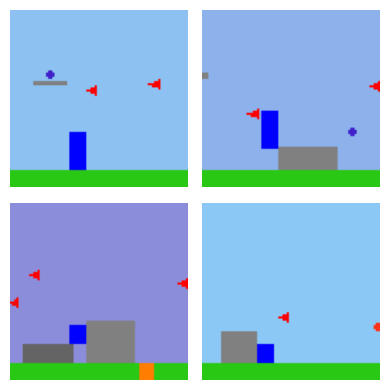

In [12]:
combine_concepts([player_right, visible_bullet], [1, 1], True)

1*lava quantity


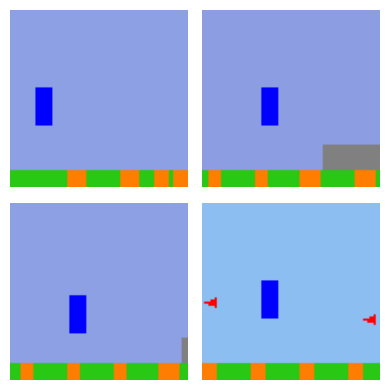

In [13]:
combine_concepts([lava_quantity], [1], True)

1*lava quantity - 1*visible bullet


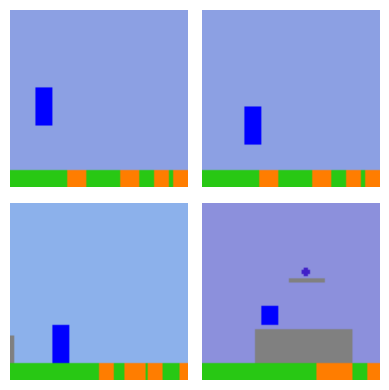

In [14]:
combine_concepts([lava_quantity, visible_bullet], [1, -1], True)

1*player standing on wall - 1*visible bullet - 2*lava quantity


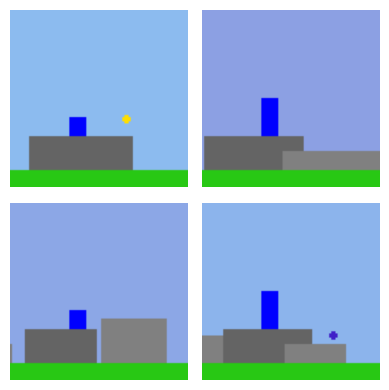

In [15]:
combine_concepts([player_standing_on_wall, visible_bullet, lava_quantity], [1, -1, -2], True)

1*player standing on wall + 1*player in air


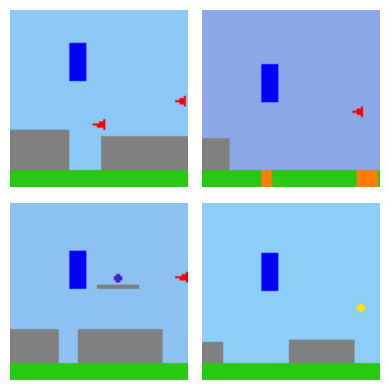

In [16]:
combine_concepts([player_standing_on_wall, player_in_air], [1, 1], True)

1*events quantity


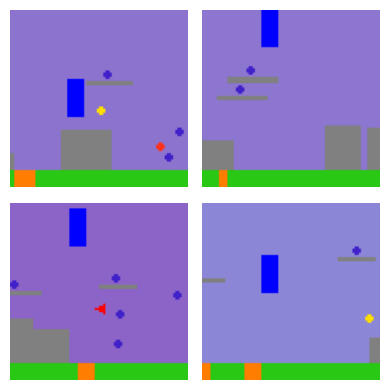

In [17]:
combine_concepts([event_quantity], [1], True)

1*events quantity - 2*good visible events


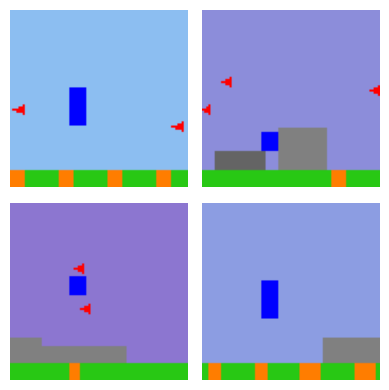

In [18]:
combine_concepts([event_quantity, good_visible_events], [1, -2], True)